In [1]:
#imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_predict,
                                     cross_validate, train_test_split)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from collections import Counter
from sklearn.linear_model import LogisticRegression
import statistics
import shap
from sksurv.ensemble import RandomSurvivalForest
from lifelines import KaplanMeierFitter


random_state = 42

In [2]:
#ds loading and variables removal 
ds = pd.read_csv(r"C:\Users\USER\OneDrive\Summer_project\Azure\annex study\ds_annex_study.csv", index_col = 'ID')
ds = ds.drop(columns=['date','DOB', 'preexisting_cond', 'twoyears', 'fiveyears', 'death'])

In [3]:
#Extra preprocessing (1-hot encoding)
ds = ds.fillna(ds.mean())
ds = ds.fillna(0)


for variable in ['COPD', 'ILD', 'NTM']:
    ds[variable][ds[variable] == 'Yes'] = 1
    ds[variable][ds[variable] == 'No'] = 0

ds['sex'][ds['sex'] == 'F'] = 0
ds['sex'][ds['sex'] == 'M'] = 1

ds.ethnicity = ds.ethnicity.astype('category').cat.codes

labels2 = ds['dead2']
labels5 = ds['dead5']

ds = ds.drop(columns = ['dead2'])

counter2 = Counter(labels2)
counter5 = Counter(labels5)

print('2 years', counter2)
print('5 years', counter5)

counter = counter5

# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
estimate2 = counter[1]/counter[0]

#dataset split 
X_train, X_test, y_train, y_test = train_test_split(ds, labels2, test_size=0.2, shuffle = True, random_state=random_state)
features = ds.columns
# ds = np.array(ds)
# labels2 = np.array(labels2)


2 years Counter({0: 61, 1: 24})
5 years Counter({0: 46, 1: 39})


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [4]:
SHAP = True

# model = RandomForestClassifier(random_state=random_state, class_weight = {0:estimate2, 1:estimate})
# model = XGBClassifier(random_state=random_state, scale_pos_weight = estimate)
# model = XGBClassifier(random_state=random_state, scale_pos_weight = estimate)
model = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
# model = LogisticRegression(random_state = random_state)
labels = labels5

#model training
skf = KFold(n_splits=5, random_state=random_state, shuffle=True)
acc = []
cms = []
f1 = []

for train_index, test_index in skf.split(ds, labels):
    X_train, X_test = ds[train_index], ds[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    print(X_test)
    xgbc = model
    xgbc.fit(X_train, y_train)
    y_pred = xgbc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cf = confusion_matrix(y_test, y_pred)
    fscore = f1_score(y_test, y_pred)
    acc.append(accuracy)
    cms.append(cf)
    f1.append(fscore)
    print('Accuracy:', round(accuracy,2))
    print('F1-score:', round(fscore,2))
    print('Confusion matrix:\n', cf)

    if SHAP:
        ex = shap.Explainer(model)
        shaps_values = ex.shap_values(X_test)
        plt.figure(figsize = (15,15))
        shap.summary_plot(shaps_values, pd.DataFrame(X_test.astype('float'), columns = features), show = True)
        plt.savefig('SHAP_CPA.png',bbox_inches='tight', dpi=300)
        SHAP = False

print('Averaged accuracy (5-folds): %.3f ±  %.3f' % (np.mean(acc), statistics.stdev(acc)))
print('Averaged f1-score (5-folds): %.3f ±  %.3f' % (np.mean(f1), statistics.stdev(f1)))



KeyError: "None of [Int64Index([ 1,  2,  3,  5,  6,  7,  8,  9, 11, 13, 14, 15, 16, 17, 19, 20, 21,\n            23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 37, 38, 39, 41, 42,\n            43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62,\n            63, 64, 65, 67, 69, 70, 71, 73, 74, 75, 76, 77, 79, 80, 81, 83,\n            84],\n           dtype='int64')] are in the [columns]"

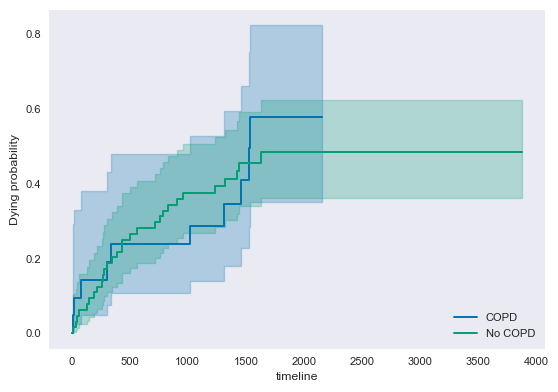

In [55]:
###COPD 
plt.style.use(['seaborn-paper', 'seaborn-dark', 'seaborn-colorblind'])
kmf_1 = KaplanMeierFitter()
kmf_0 = KaplanMeierFitter()

pos = ds.query('COPD == 1')
neg = ds.query('COPD == 0')

kmf_1.fit(durations =  pos["surv"],event_observed = pos["dead5"] ,label="COPD")
kmf_0.fit(durations =  neg["surv"],event_observed = neg["dead5"], label="No COPD")
# print (kmf_1.event_table)
# print (kmf_0.event_table)

# print (kmf_1.predict(11))
# print (kmf_0.predict(11))

# print (kmf_1.survival_function_)
# print (kmf_0.survival_function_)

# Plot the survival_function data :
# kmf_1.plot()
# kmf_0.plot()

fig, ax = plt.subplots()

plt.xlabel("Days passed")
plt.ylabel("Dying probability")



kmf_1.plot_cumulative_density()
kmf_0.plot_cumulative_density()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
legend = ax.legend(loc='lower right')


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


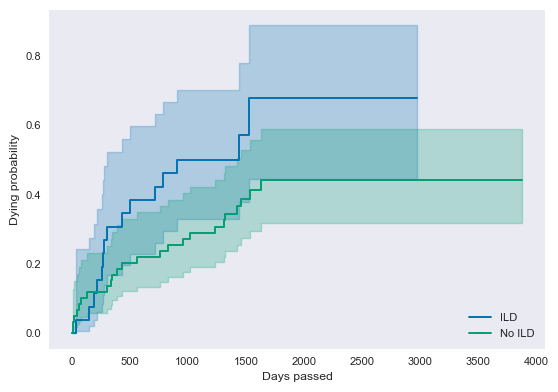

In [36]:
###ILD 
print(plt.style.available)
plt.rcdefaults() 
plt.style.use(['seaborn-paper', 'seaborn-dark', 'seaborn-colorblind'])

kmf_1 = KaplanMeierFitter()
kmf_0 = KaplanMeierFitter()

pos = ds.query('ILD == 1')
neg = ds.query('ILD == 0')

kmf_1.fit(durations =  pos["surv"],event_observed = pos["dead5"] ,label="ILD")
kmf_0.fit(durations =  neg["surv"],event_observed = neg["dead5"], label="No ILD")
# print (kmf_1.event_table)
# print (kmf_0.event_table)

# print (kmf_1.predict(11))
# print (kmf_0.predict(11))

# print (kmf_1.survival_function_)
# print (kmf_0.survival_function_)

# Plot the survival_function data :
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



kmf_1.plot_cumulative_density()
kmf_0.plot_cumulative_density()
plt.xlabel("Days passed")
plt.ylabel("Dying probability")
legend = ax.legend(loc='lower right')
ax.grid(False)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


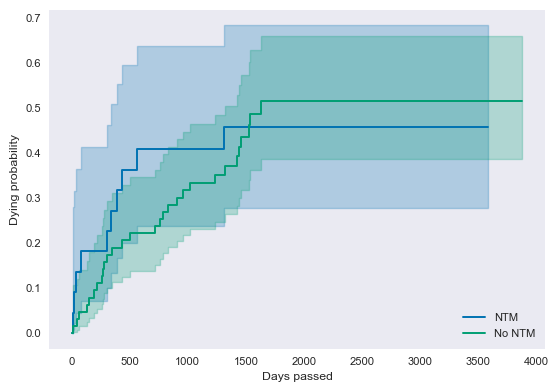

In [38]:
###NTM 
print(plt.style.available)
plt.style.use(['seaborn-paper', 'seaborn-dark', 'seaborn-colorblind'])
kmf_1 = KaplanMeierFitter()
kmf_0 = KaplanMeierFitter()

pos = ds.query('NTM == 1')
neg = ds.query('NTM == 0')

kmf_1.fit(durations =  pos["surv"],event_observed = pos["dead5"] ,label="NTM")
kmf_0.fit(durations =  neg["surv"],event_observed = neg["dead5"], label="No NTM")
# print (kmf_1.event_table)
# print (kmf_0.event_table)

# print (kmf_1.predict(11))
# print (kmf_0.predict(11))

# print (kmf_1.survival_function_)
# print (kmf_0.survival_function_)

# Plot the survival_function data :
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.title("KMF")

kmf_1.plot_cumulative_density()
kmf_0.plot_cumulative_density()
plt.xlabel("Days passed")
plt.ylabel("Dying probability")
legend = ax.legend(loc='lower right')
ax.grid(False)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


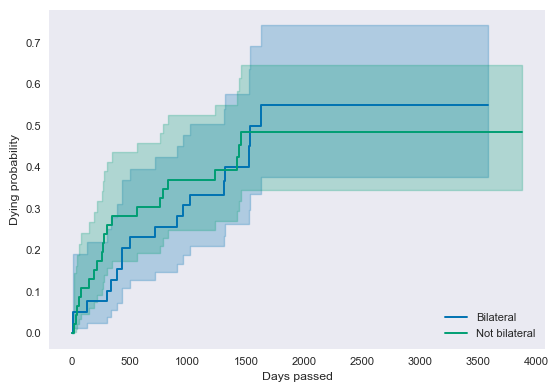

In [45]:
###NTM 
print(plt.style.available)
plt.style.use(['seaborn-paper', 'seaborn-dark', 'seaborn-colorblind'])
kmf_1 = KaplanMeierFitter()
kmf_0 = KaplanMeierFitter()

pos = ds.query('summary == 1')
neg = ds.query('summary == 0')

kmf_1.fit(durations =  pos["surv"],event_observed = pos["dead5"] ,label="Bilateral")
kmf_0.fit(durations =  neg["surv"],event_observed = neg["dead5"], label="Not bilateral")
# print (kmf_1.event_table)
# print (kmf_0.event_table)

# print (kmf_1.predict(11))
# print (kmf_0.predict(11))

# print (kmf_1.survival_function_)
# print (kmf_0.survival_function_)

# Plot the survival_function data :
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.title("KMF")

kmf_1.plot_cumulative_density()
kmf_0.plot_cumulative_density()
plt.xlabel("Days passed")
plt.ylabel("Dying probability")
legend = ax.legend(loc='lower right')
ax.grid(False)


In [54]:
#COX hazard model with or without CT scan data

from lifelines import CoxPHFitter
data_full = ds.drop(columns = ['BR', 'ER'])
data_no_ct = ds.drop(columns = ['FL', 'FB', 'SB', 'BB', 'BR', 'BL', 'ER', 'EB', 'GR', 'GL', 'GB',
       'CB', 'CR', 'CL', 'cavities', 'fungal_balls', 'pleura_thickening',
       'summary'])




cph_full = CoxPHFitter()
cph_full.fit(data_full,"surv",event_col="dead5")
cph_full.print_summary()


cph_no_ct = CoxPHFitter()
cph_no_ct.fit(data_no_ct,"surv",event_col="dead5")
cph_no_ct.print_summary()



# # Plot the survival function :
# d_data = data_full.iloc[0:5,:]
# cph.predict_survival_function(d_data).plot()



<lifelines.CoxPHFitter: fitted with 85 total observations, 46 right-censored observations>
             duration col = 'surv'
                event col = 'dead5'
      baseline estimation = breslow
   number of observations = 85
number of events observed = 39
   partial log-likelihood = -140.89
         time fit was run = 2022-08-17 17:13:16 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
sex                 0.72       2.05       0.49            -0.24             1.67                 0.79                 5.30
age                 0.04       1.04       0.02             0.01             0.08                 1.01                 1.08
ethnicity           0.14       1.15       0.10            -0.05             0.33                 0.95                 1.39
crp                 0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
albumin            -0.01       0.99       0.05            -0.12             0.09                 0.89                 1.09
BMI                -0.08       0.93       0.07            -0.22             0.07                 0.80                 1.07
COPD               -0.24       0.79       0.57            -1.36             0.88                 0.26                 2.40
ILD                 1.65       5.19       0.83             0.01             3.28                 1.01                26.63
NTM                 0.28       1.33       0.49            -0.68             1.24                 0.51                 3.47
FL                 -2.98       0.05       1.81            -6.53             0.57                 0.00                 1.77
FB                  0.20       1.22       0.84            -1.45             1.85                 0.23                 6.36
SB                 -2.09       0.12       1.01            -4.07            -0.10                 0.02                 0.90
BB                  1.13       3.10       0.62            -0.09             2.35                 0.91                10.50
BL                 -1.15       0.32       1.02            -3.15             0.85                 0.04                 2.35
EB                  0.56       1.75       0.55            -0.52             1.64                 0.60                 5.14
GR                  1.98       7.26       0.94             0.13             3.83                 1.14                46.04
GL                  1.22       3.38       1.30            -1.34             3.77                 0.26                43.42
GB                 -0.24       0.79       0.97            -2.13             1.66                 0.12                 5.26
CB                 -0.23       0.80       0.56            -1.33             0.88                 0.26                 2.41
CR                  0.19       1.21       0.57            -0.92             1.31                 0.40                 3.71
CL                  0.10       1.10       0.67            -1.22             1.42                 0.30                 4.13
cavities            1.12       3.06       0.88            -0.60             2.84                 0.55                17.06
fungal_balls        0.26       1.30       0.81            -1.33             1.85                 0.26                 6.37
pleura_thickening   0.32       1.38       0.73            -1.11             1.76                 0.33                 5.80
summary            -1.03       0.36       1.04            -3.08             1.01                 0.05                 2.75

                    cmp to     z    p   -log2(p)
covariate                                       
sex                   0.00  1.47 0.14       2.83
age                   0.00  2.46 0.01       6.18
ethnicity             0.00  1.42 0.16       2.69
crp                   0.00  2.22 0.03       5.25
albumin               0.00 -0.2

<lifelines.CoxPHFitter: fitted with 85 total observations, 46 right-censored observations>
             duration col = 'surv'
                event col = 'dead5'
      baseline estimation = breslow
   number of observations = 85
number of events observed = 39
   partial log-likelihood = -148.10
         time fit was run = 2022-08-17 17:13:16 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex         0.37       1.45       0.36            -0.33             1.08                 0.72                 2.95
age         0.03       1.03       0.01             0.00             0.06                 1.00                 1.06
ethnicity   0.09       1.10       0.07            -0.04             0.22                 0.96                 1.25
crp         0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
albumin    -0.07       0.93       0.04            -0.16             0.01                 0.85                 1.01
BMI        -0.05       0.95       0.06            -0.16             0.06                 0.85                 1.06
COPD       -0.17       0.84       0.46            -1.08             0.73                 0.34                 2.07
ILD         1.03       2.80       0.42             0.20             1.86                 1.22                 6.44
NTM         0.29       1.34       0.42            -0.52             1.11                 0.59                 3.03

            cmp to     z    p   -log2(p)
covariate                               
sex           0.00  1.03 0.30       1.73
age           0.00  2.23 0.03       5.28
ethnicity     0.00  1.37 0.17       2.54
crp           0.00  2.40 0.02       5.95
albumin       0.00 -1.68 0.09       3.44
BMI           0.00 -0.93 0.35       1.50
COPD          0.00 -0.38 0.71       0.50
ILD           0.00  2.43 0.02       6.04
NTM           0.00  0.70 0.48       1.05
---
Concordance = 0.71
Partial AIC = 314.20
log-likelihood ratio test = 22.59 on 9 df
-log2(p) of ll-ratio test = 7.12